In [1]:
# Import Required Libraries
import pandas as pd
import re
import string
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from datasets import load_dataset


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# loading data

In [3]:
data_file_path = "/content/Total_final_dataset.csv" # Adjust path if necessary


try:
    # Read the single CSV file into a pandas DataFrame
    full_df = pd.read_csv(data_file_path)
    print("- Full DataFrame loaded.")
    print(f"Full dataset shape: {full_df.shape}")

    total_sample_size = 50000
    if len(full_df) > total_sample_size:
        print(f"Sampling {total_sample_size} examples from the full dataset...")
        sampled_df = full_df.sample(n=total_sample_size, random_state=42)
    else:
        print("Dataset size is less than or equal to sample size, using full dataset.")
        sampled_df = full_df.copy()

    print(f"Sampled DataFrame shape: {sampled_df.shape}")
    print("\nSampled DataFrame head:")
    print(sampled_df.head())


except FileNotFoundError:
    print(f"\nError: Make sure '{data_file_path}' is uploaded to Colab or the correct path is specified.")
    raise
except Exception as e:
    print(f"\nAn error occurred while reading or sampling CSV file: {e}")
    raise

print("\nFormatting Sampled DataFrame (Extracting one correction from 'target')...")

# Function to format a single DataFrame (using input -> incorrect mapping)
def format_gec_df(df):
    if 'input' not in df.columns or 'target' not in df.columns:
        raise ValueError("DataFrame must contain 'input' and 'target' columns.")

    formatted_df = df[["input", "target"]].copy()

    def get_first_correction(target_string):
        if isinstance(target_string, str):
            corrections = target_string.split(',')
            if corrections:
                return corrections[0].strip()
        return ""

    formatted_df["corrected"] = formatted_df["target"].apply(get_first_correction)
    formatted_df = formatted_df.drop(columns=["target"])
    formatted_df = formatted_df.rename(columns={"input": "incorrect"})
    return formatted_df

try:
    # Apply formatting to the sampled DataFrame
    formatted_sampled_df = format_gec_df(sampled_df)
    print("Sampled DataFrame formatted successfully.")
    print("\nFormatted Sampled DataFrame head (Incorrect -> Corrected):")
    print(formatted_sampled_df.head())
    print(f"\nFormatted Sampled DataFrame shape: {formatted_sampled_df.shape}")

except Exception as e:
    print(f"An error occurred during DataFrame formatting: {e}")
    raise e



train_size_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1


# First split: Separate out the main training set and the rest (validation + test)
print(f"\nSplitting sampled data into Train ({train_size_ratio*100}%), Validation/Test ({(validation_ratio+test_ratio)*100}%)...")
train_df_final, val_test_df_final = train_test_split(
    formatted_sampled_df,
    train_size=train_size_ratio,
    random_state=42,
)
print(f"- Train split shape: {train_df_final.shape}")
print(f"- Validation/Test split shape: {val_test_df_final.shape}")


print(f"\nSplitting Validation/Test data into Validation ({validation_ratio/(validation_ratio+test_ratio)*100}%) and Test ({test_ratio/(validation_ratio+test_ratio)*100}%)...")
validation_df_final, test_df_final = train_test_split(
    val_test_df_final,
    test_size=test_ratio / (validation_ratio + test_ratio), # Calculate test size relative to val_test split
    random_state=42,
)
print(f"- Validation split shape: {validation_df_final.shape}")
print(f"- Test split shape: {test_df_final.shape}")


print("\nAssigning split DataFrames to variables for cleaning/tokenization step:")

train_df_cleaned_input = train_df_final
eval_df_cleaned_input = validation_df_final # Use validation for eval during training
test_df_cleaned_input = test_df_final     # Use test for final evaluation/Gradio

print(f"- train_df_cleaned_input shape: {train_df_cleaned_input.shape}")
print(f"- eval_df_cleaned_input shape: {eval_df_cleaned_input.shape}")
print(f"- test_df_cleaned_input shape: {test_df_cleaned_input.shape}")

print("\nData splitting complete. Proceed to the cleaning and tokenization step (Step 3).")

- Full DataFrame loaded.
Full dataset shape: (67645, 2)
Sampling 50000 examples from the full dataset...
Sampled DataFrame shape: (50000, 2)

Sampled DataFrame head:
                                                   input  \
65274  The crowd at Millthorpe train station on the o...   
60459  Candidate should grow up about the outbinds sa...   
52367  The next few screens marked customization of t...   
55188  Since June of 2018 —​ independett Member of Bo...   
27942                   Has Superman even said, “Ouch!”?   

                                                  target  
65274  The crowd at Millthorpe train station on the o...  
60459  Candidate should have knowledge about the outb...  
52367  The next few screens involved customizing the ...  
55188  Since June 2018 —​ independent Member of the B...  
27942                   Has Superman ever said, “Ouch!”?  

Formatting Sampled DataFrame (Extracting one correction from 'target')...
Sampled DataFrame formatted successfully.

F

# cleaning n preprocessing data



In [4]:

# Assign the *final split* DataFrames from Step 2 (which are already formatted)
train_df_cleaned_input = train_df_final
eval_df_cleaned_input = validation_df_final # Use validation for eval during training
test_df_cleaned_input = test_df_final     # Use test for final evaluation/Gradio


# --- Define Cleaning Function (for pandas Series) ---
def clean_series(series):
    cleaned_list = []
    translator = str.maketrans('', '', string.punctuation + string.digits)
    for text in series:
        if isinstance(text, str):
            text = " ".join(text.split())
            text = text.lower()
            text = text.translate(translator)
        else:
            text = "" # Handle non-string entries gracefully
        cleaned_list.append(text)
    return pd.Series(cleaned_list, index=series.index)

print("Cleaning text in DataFrames...")

# Apply cleaning
train_df_cleaned = train_df_cleaned_input.copy()
eval_df_cleaned = eval_df_cleaned_input.copy()
test_df_cleaned = test_df_cleaned_input.copy()

train_df_cleaned['incorrect'] = clean_series(train_df_cleaned['incorrect'])
train_df_cleaned['corrected'] = clean_series(train_df_cleaned['corrected'])

eval_df_cleaned['incorrect'] = clean_series(eval_df_cleaned['incorrect'])
eval_df_cleaned['corrected'] = clean_series(eval_df_cleaned['corrected'])

test_df_cleaned['incorrect'] = clean_series(test_df_cleaned['incorrect'])
test_df_cleaned['corrected'] = clean_series(test_df_cleaned['corrected'])

print("Text cleaning complete.")


# --- Drop rows with empty input or target after cleaning ---
print("Dropping rows with empty incorrect or corrected sentences after cleaning...")
original_train_rows = len(train_df_cleaned)
original_eval_rows = len(eval_df_cleaned)
original_test_rows = len(test_df_cleaned)

train_df_cleaned = train_df_cleaned[
    (train_df_cleaned['incorrect'].str.len() > 0) &
    (train_df_cleaned['corrected'].str.len() > 0)
].reset_index(drop=True)

eval_df_cleaned = eval_df_cleaned[
    (eval_df_cleaned['incorrect'].str.len() > 0) &
    (eval_df_cleaned['corrected'].str.len() > 0)
].reset_index(drop=True)

test_df_cleaned = test_df_cleaned[
    (test_df_cleaned['incorrect'].str.len() > 0) &
    (test_df_cleaned['corrected'].str.len() > 0)
].reset_index(drop=True)

print(f"- Dropped {original_train_rows - len(train_df_cleaned)} rows from train.")
print(f"- Dropped {original_eval_rows - len(eval_df_cleaned)} rows from eval.")
print(f"- Dropped {original_test_rows - len(test_df_cleaned)} rows from test.")


print("\nCleaned Train DataFrame head:")
print(train_df_cleaned.head())

# --- Add Special Tokens to Target (Corrected) Side ---
print("\nAdding SOS/EOS tokens to corrected sentences...")
train_df_cleaned['corrected'] = train_df_cleaned['corrected'].apply(lambda x: 'sos ' + x + ' eos')
eval_df_cleaned['corrected'] = eval_df_cleaned['corrected'].apply(lambda x: 'sos ' + x + ' eos')
test_df_cleaned['corrected'] = test_df_cleaned['corrected'].apply(lambda x: 'sos ' + x + ' eos')

print("Special tokens added.")
print("\nTrain DataFrame head with special tokens in 'corrected':")
print(train_df_cleaned.head())


# --- Build Keras Tokenizer Vocabulary ---
# Collect all cleaned text *after* dropping empty rows
all_input_text = pd.concat([train_df_cleaned['incorrect'], eval_df_cleaned['incorrect'], test_df_cleaned['incorrect']])
all_target_text = pd.concat([train_df_cleaned['corrected'], eval_df_cleaned['corrected'], test_df_cleaned['corrected']])
all_text = pd.concat([all_input_text, all_target_text])

print(f"\nBuilding Keras Tokenizer vocabulary from {len(all_text)} sentences...")
# --- Robustness: Limit vocabulary size ---
VOCAB_LIMIT = 20000
keras_tokenizer = Tokenizer(num_words=VOCAB_LIMIT, oov_token='<unk>')
keras_tokenizer.fit_on_texts(all_text)


VOCAB_SIZE = len(keras_tokenizer.word_index) + 1
actual_vocab_size = len(keras_tokenizer.word_index)
print(f"Tokenizer fitted vocabulary size (including OOV): {actual_vocab_size}")
print(f"Final VOCAB_SIZE for model (includes padding): {VOCAB_SIZE}")


# Tokenize and Pad Sequences
# Convert text to sequences of integers using the fitted tokenizer
train_input_sequences = keras_tokenizer.texts_to_sequences(train_df_cleaned['incorrect'])
train_target_sequences = keras_tokenizer.texts_to_sequences(train_df_cleaned['corrected'])

eval_input_sequences = keras_tokenizer.texts_to_sequences(eval_df_cleaned['incorrect'])
eval_target_sequences = keras_tokenizer.texts_to_sequences(eval_df_cleaned['corrected'])

test_input_sequences = keras_tokenizer.texts_to_sequences(test_df_cleaned['incorrect'])
test_target_sequences = keras_tokenizer.texts_to_sequences(test_df_cleaned['corrected'])


# Determine max sequence length *after* tokenization
print("\nCalculating max sequence lengths...")
all_sequences = train_input_sequences + train_target_sequences + \
                eval_input_sequences + eval_target_sequences + \
                test_input_sequences + test_target_sequences

max_len_calculated = max(len(seq) for seq in all_sequences) if all_sequences else 0
print(f"Calculated max sequence length across all data: {max_len_calculated}")

fixed_max_len = min(max_len_calculated + 5, 128)
print(f"Using a fixed max length for padding of: {fixed_max_len}")


# Pad sequences
train_input_padded = pad_sequences(train_input_sequences, maxlen=fixed_max_len, padding='post')
train_target_padded = pad_sequences(train_target_sequences, maxlen=fixed_max_len, padding='post')

eval_input_padded = pad_sequences(eval_input_sequences, maxlen=fixed_max_len, padding='post')
eval_target_padded = pad_sequences(eval_target_sequences, maxlen=fixed_max_len, padding='post')

test_input_padded = pad_sequences(test_input_sequences, maxlen=fixed_max_len, padding='post')
test_target_padded = pad_sequences(test_target_sequences, maxlen=fixed_max_len, padding='post')


X_train = train_input_padded
y_train = train_target_padded

X_test = eval_input_padded
y_test = eval_target_padded

X_final_test = test_input_padded
y_final_test = test_target_padded

MAX_INPUT_LEN = fixed_max_len
MAX_TARGET_LEN = fixed_max_len

word_to_index = keras_tokenizer.word_index
index_to_word = keras_tokenizer.index_word
sos_token_id = word_to_index.get('sos')
eos_token_id = word_to_index.get('eos')

print("\nTokenization and padding complete.")

print("\nFinal Data Parameters:")
print(f"Vocabulary Size (VOCAB_SIZE): {VOCAB_SIZE}")
print(f"Max Input Sequence Length (MAX_INPUT_LEN): {MAX_INPUT_LEN}")
print(f"Max Target Sequence Length (MAX_TARGET_LEN): {MAX_TARGET_LEN}")

print("\nShapes of processed data for Keras:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test (used for validation during training) shape: {X_test.shape}")
print(f"y_test (used for validation during training) shape: {y_test.shape}")
print(f"X_final_test (separate test set) shape: {X_final_test.shape}")
print(f"y_final_test (separate test set) shape: {y_final_test.shape}")

print("\nExample of final tokenized/padded data:")
if len(X_train) > 0:
     print(f"Input IDs (Train[0]): {X_train[0][:20]}...")
     print(f"Target IDs (Train[0]): {y_train[0][:20]}...")
else:
     print("Train data is empty after processing.")

Cleaning text in DataFrames...
Text cleaning complete.
Dropping rows with empty incorrect or corrected sentences after cleaning...
- Dropped 63 rows from train.
- Dropped 8 rows from eval.
- Dropped 8 rows from test.

Cleaned Train DataFrame head:
                                           incorrect  \
0  lady’s mantle the herb helped preventing skin ...   
1  spraring new ring collection that starts exclu...   
2  the report credits delach for meeting city goa...   
3  does i need to offer visa for layover at beiijing   
4  sep   · took walk around deer island today com...   

                                           corrected  
0  lady’s mantle this herb helps prevent skin fro...  
1                             new earring collection  
2   the report credits delach for meeting city goals  
3    do i need to apply visa for layover at beiijing  
4                                               sep   

Adding SOS/EOS tokens to corrected sentences...
Special tokens added.

Train DataFra

## Model Building

In [5]:
# Import Required Modules
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Embedding, Concatenate, Dense, Layer
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [6]:
#Step 1: Define the Custom Attention Layer
class AttentionLayer(Layer):
    """
    Implements Bahdanau-style attention mechanism.
    It aligns decoder outputs with encoder outputs and returns a context vector.
    """
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def call(self, inputs):
        encoder_outputs, decoder_outputs = inputs

        score = K.batch_dot(decoder_outputs, encoder_outputs, axes=[2, 2])

        attention_weights = K.softmax(score, axis=-1)
        context_vector = K.batch_dot(attention_weights, encoder_outputs, axes=[2,1])

        return context_vector, attention_weights

In [7]:
# Input for the encoder (Input sentences)

encoder_inputs = Input(shape=(MAX_INPUT_LEN,), name='encoder_inputs')

# Embedding for the encoder
embedding_dim = 1024
enc_emb = Embedding(input_dim=VOCAB_SIZE, output_dim=embedding_dim, name='encoder_embedding')(encoder_inputs)

# Bidirectional LSTM for encoder
lstm_units = 256
enc_lstm = Bidirectional(LSTM(lstm_units, return_sequences=True, return_state=True), name='bidirectional_encoder')
encoder_outputs, forward_h, forward_c, backward_h, backward_c = enc_lstm(enc_emb)

state_h = Concatenate(name='encoder_state_h')([forward_h, backward_h])
state_c = Concatenate(name='encoder_state_c')([forward_c, backward_c])
encoder_states = [state_h, state_c]

print("Encoder part defined.")

Encoder part defined.


In [8]:
# Input for the decoder
decoder_inputs = Input(shape=(None,), name='decoder_inputs')

# Embedding for the decoder
# Use the same vocabulary size and embedding dimension as the encoder
dec_emb_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=embedding_dim, name='decoder_embedding')
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM (512 units to match encoder's concatenated state)

decoder_lstm = LSTM(512, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

print("Decoder part defined.")

Decoder part defined.


In [9]:
 # Apply Attention
attention_layer = AttentionLayer(name='attention_layer')
attention_output, attention_weights = attention_layer([encoder_outputs, decoder_outputs])

# Concatenate attention output with decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_output])

In [10]:
# Final Dense layer with softmax activation to predict next word
decoder_dense = Dense(VOCAB_SIZE, activation='softmax', name='output_layer')
decoder_outputs = decoder_dense(decoder_concat_input)

print("Output layer defined.")

Output layer defined.


In [11]:
# Define the complete model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary to verify
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 128, 1024) │ 75,589,632 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_enco… │ [(None, 128,      │  2,623,488 │ encoder_embeddin… │
│ (Bidirectional)     │ 512), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None,      │ 75,589,632 │ decoder_inputs[0… │
│ (Embedding)         │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_state_h     │ (None, 512)       │          0 │ bidirectional_en… │
│ (Concatenate)       │                   │            │ bidirectional_en… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_state_c     │ (None, 512)       │          0 │ bidirectional_en… │
│ (Concatenate)       │                   │            │ bidirectional_en… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, None,     │  3,147,776 │ decoder_embeddin… │
│                     │ 512), (None,      │            │ encoder_state_h[… │
│                     │ 512), (None,      │            │ encoder_state_c[… │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ [(None, None,     │          0 │ bidirectional_en… │
│ (AttentionLayer)    │ 512), (None,      │            │ decoder_lstm[0][… │
│                     │ None, 128)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None,      │          0 │ decoder_lstm[0][… │
│ (Concatenate)       │ 1024)             │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, None,      │ 75,663,450 │ concat_layer[0][… │
│ (Dense)             │ 73818)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 232,613,978 (887.35 MB)

 Trainable params: 232,613,978 (887.35 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import numpy as np # Make sure numpy is imported


save_dir = "/content/drive/MyDrive/sentence_corrector"
os.makedirs("checkpoints", exist_ok=True) # This creates a 'checkpoints' folder in the *Colab environment*, not Drive
checkpoint_path = os.path.join(save_dir, "checkpoints", "gec_simplifier_best_model.weights.h5") # Save checkpoints to Drive

# Ensure the directory for checkpoints in Drive exists
os.makedirs(os.path.join(save_dir, "checkpoints"), exist_ok=True)


checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1, # Set verbose to see when checkpoints are saved
                             save_best_only=True,
                             save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
callbacks_list = [checkpoint, early_stopping] # Keep early stopping for now, helps if training converges quickly

# Prepare training and validation data
# These variables (X_train, y_train, X_test, y_test) should be available from Step 3
encoder_input_data = X_train
decoder_input_data = y_train[:, :-1] # Shifted target for decoder input
decoder_target_data = y_train[:, 1:]  # Shifted target for loss calculation

encoder_input_test = X_test          # Using validation set from Step 2 as test set for Keras training validation
decoder_input_test = y_test[:, :-1]  # Shifted validation target for decoder input
decoder_target_test = y_test[:, 1:]   # Shifted validation target for loss calculation


# Train the model

EPOCHS = 5
BATCH_SIZE = 16



print(f"Starting training for {EPOCHS} epoch(s) with BATCH_SIZE={BATCH_SIZE}...")

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
                    callbacks=callbacks_list)

print("\nTraining finished.")

# Save final model weights
final_weights_save_path = os.path.join(save_dir, "gec_simplifier_final_model.weights.h5")
model.save_weights(final_weights_save_path)

Starting training for 5 epoch(s) with BATCH_SIZE=16...
Epoch 1/5
2497/2497 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9161 - loss: 0.7862
Epoch 1: val_accuracy improved from -inf to 0.95781, saving model to /content/drive/MyDrive/sentence_corrector/checkpoints/gec_simplifier_best_model.weights.h5
2497/2497 ━━━━━━━━━━━━━━━━━━━━ 327s 129ms/step - accuracy: 0.9161 - loss: 0.7861 - val_accuracy: 0.9578 - val_loss: 0.3308
Epoch 2/5
2497/2497 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9648 - loss: 0.2613
Epoch 2: val_accuracy improved from 0.95781 to 0.97238, saving model to /content/drive/MyDrive/sentence_corrector/checkpoints/gec_simplifier_best_model.weights.h5
2497/2497 ━━━━━━━━━━━━━━━━━━━━ 333s 133ms/step - accuracy: 0.9648 - loss: 0.2613 - val_accuracy: 0.9724 - val_loss: 0.2139
Epoch 3/5
2497/2497 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9785 - loss: 0.1365
Epoch 3: val_accuracy improved from 0.97238 to 0.97404, saving model to /content/drive/MyDrive/sentence_corre

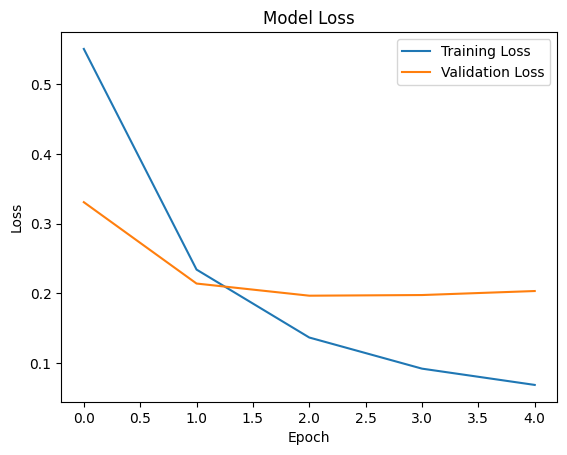

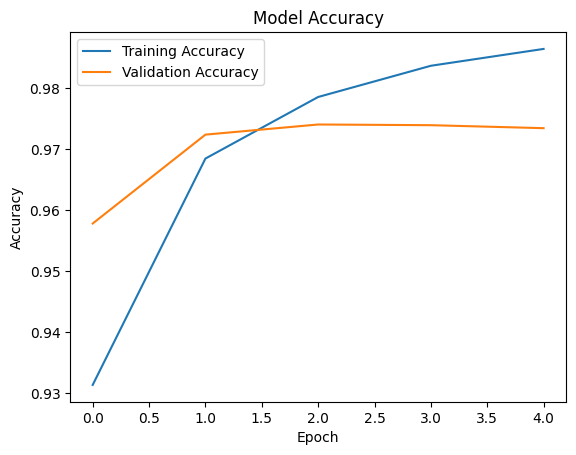

In [14]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Inference Model

In [15]:
# Recalculate max lengths from the data we used for training/validation

max_eng_len = X_test.shape[1]
max_tur_len = y_test.shape[1]

# Update index/word mappings from the single Keras tokenizer
eng_index_word = keras_tokenizer.index_word # Input language mappings
eng_word_index = keras_tokenizer.word_index # Input language mappings

tur_index_word = keras_tokenizer.index_word # Target language mappings (same as input language)
tur_word_index = keras_tokenizer.word_index # Target language mappings (same as input language)

# Also ensure VOCAB_SIZE is the global VOCAB_SIZE from Step 3g
# VOCAB_SIZE = len(keras_tokenizer.word_index) + 1 # Already calculated in Step 3

In [16]:

if 'X_test' in globals() and 'y_test' in globals():
     max_eng_len_check = X_test.shape[1]
     max_tur_len_check = y_test.shape[1]
     # Verify they match the global MAX_ variables
     if max_eng_len_check != MAX_INPUT_LEN or max_tur_len_check != MAX_TARGET_LEN:
          print("Warning: Data shapes do not match global MAX_LEN variables!")
          print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
          print(f"Global MAX_INPUT_LEN: {MAX_INPUT_LEN}, MAX_TARGET_LEN: {MAX_TARGET_LEN}")
     # Use the global variables for model definition, they should be correct from Step 3
     # max_eng_len = MAX_INPUT_LEN
     # max_tur_len = MAX_TARGET_LEN # Not directly used in inference model inputs definition below, but good to know
else:
     print("Error: X_test or y_test not found. Cannot verify max lengths for inference model.")
     # Need to make sure the model definition below uses MAX_INPUT_LEN which should be correct from Step 3
     # If MAX_INPUT_LEN is also not defined, you must go back and run Step 3.


# --- Encoder Inference Model ---
# This model takes the input sequence and outputs the final encoder states.
# Reuse the layers from the training model definition (they should be available if you ran Step 4).
encoder_model = Model(
    inputs=encoder_inputs, # The input layer defined in Step 4
    outputs=[encoder_outputs, state_h, state_c] # Outputs from Step 4
)
print("Encoder inference model defined.")



# Inputs for the decoder inference model
decoder_inputs_inf = Input(shape=(1,), name='decoder_word_input') # Takes one token at a time
decoder_state_input_h = Input(shape=(512,), name='decoder_input_h') # Takes previous hidden state
decoder_state_input_c = Input(shape=(512,), name='decoder_input_c') # Takes previous cell state

decoder_hidden_state_input = Input(shape=(MAX_INPUT_LEN, 512), name='encoder_outputs_input')


dec_emb_inf = dec_emb_layer(decoder_inputs_inf)

decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(
    dec_emb_inf, initial_state=[decoder_state_input_h, decoder_state_input_c]
)

# Apply Attention
attention_output_inf, attention_weights_inf = attention_layer(
    [decoder_hidden_state_input, decoder_outputs_inf]) # Inputs are encoder outputs and current decoder output

# Concatenate attention output with decoder LSTM output
decoder_concat_inf = Concatenate(axis=-1)([decoder_outputs_inf, attention_output_inf])

# Final Dense layer to predict next word
decoder_outputs_final = decoder_dense(decoder_concat_inf)

# Define the complete decoder inference model
decoder_model = Model(
    inputs=[decoder_inputs_inf, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    outputs=[decoder_outputs_final, state_h_inf, state_c_inf, attention_weights_inf] # Output next token probabilities, new states, and attention
)
print("Decoder inference model defined.")

print("\nKeras Inference models built.")

Encoder inference model defined.
Decoder inference model defined.

Keras Inference models built.


##prediction Model

In [19]:
word_to_index = keras_tokenizer.word_index
index_to_word = keras_tokenizer.index_word

#  start and end token IDs
sos_token_id = word_to_index.get('sos')
eos_token_id = word_to_index.get('eos')
#  padding token ID as 0
pad_token_id = 0




def clean_input_text_for_prediction(text):
    # Apply the same cleaning as training data
    text = " ".join(text.split())
    text = text.lower()
    translator = str.maketrans('', '', string.punctuation + string.digits)
    text = text.translate(translator)
    return text


def get_predicted_sentence_with_attention(input_raw_text):
    # 1. Clean the input text
    input_cleaned = clean_input_text_for_prediction(input_raw_text)

    # 2. Tokenize and pad the input sequence
    input_sequence = keras_tokenizer.texts_to_sequences([input_cleaned])
    input_padded = pad_sequences(input_sequence, maxlen=MAX_INPUT_LEN, padding='post')

    # 3. Get encoder output and states
    # encoder_model expects batch size 1 for a single input
    enc_output, enc_h, enc_c = encoder_model.predict(input_padded)

    # 4. Initialize decoder input and states
    # Start with the SOS token for the target sequence
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = sos_token_id # Use the ID of the 'sos' token

    # Initialize decoder states with encoder states
    states_values = [enc_h, enc_c]

    decoded_sentence = []
    attention_weights_list = []
    stop_condition = False
    max_decoder_length = MAX_TARGET_LEN # Prevent infinite loops

    # 5. Loop for decoding
    while not stop_condition:
        # Predict next token, get new states and attention weights
        output_tokens, h, c, attn_weights = decoder_model.predict(
            [target_seq, enc_output, states_values[0], states_values[1]])

        # Get the most likely token ID
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        # 6. Decode and check for EOS or max length
        if sampled_token_index == eos_token_id or len(decoded_sentence) >= max_decoder_length:
             # Stop condition met (generated EOS or reached max length)
            stop_condition = True
        else:
            # Append the decoded word
            sampled_word = index_to_word.get(sampled_token_index, '<unk>')
            decoded_sentence.append(sampled_word)


            attention_weights_list.append(attn_weights[0, 0])

        # 7. Update decoder input and states for the next time step
        # The input token for the next step is the token just generated
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_values = [h, c]

    # Return the decoded sentence as a string
    return ' '.join(decoded_sentence), np.array(attention_weights_list)


# --- Test the prediction function ---
# Pick a test sample from your separate test set (X_final_test, y_final_test)
if len(X_final_test) > 0:
    # Initialize variables with default values
    original_input_raw = "Test input"
    original_target_raw = "Test target"

    if 'eval_df_cleaned_input' in globals() and len(eval_df_cleaned_input) > 0:
         sample_index = np.random.randint(0, len(eval_df_cleaned_input))
         original_input_raw = eval_df_cleaned_input['incorrect'].iloc[sample_index]
         original_target_raw = eval_df_cleaned_input['corrected'].iloc[sample_index]

    print(f"\nTesting prediction function with sample input:")
    print(f"Original Input: {original_input_raw}")
    print(f"Actual Corrected: {original_target_raw}")


    predicted_sentence, attention_matrix = get_predicted_sentence_with_attention(original_input_raw)

    print(f"\nPredicted Corrected: {predicted_sentence}")

else:
    print("\nX_final_test is empty, cannot test prediction function.")


Testing prediction function with sample input:
Original Input: Contacting the Recording Division at 425-388-3483 some additional questions.
Actual Corrected: Contact the Recording Division at 425-388-3483 with additional questions.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Predicted Corrected: the recording division at some additional questions


In [20]:
import gradio as gr

def gradio_predict_correction(input_raw_text):
    """
    Wrapper function to call the prediction function and return only the string output.
    Designed to be used as the 'fn' for the Gradio interface.
    """
    # Call your main prediction function. It returns the decoded string and attention weights.
    predicted_sentence, attention_matrix = get_predicted_sentence_with_attention(input_raw_text)

    # Return *only* the predicted sentence string for Gradio
    return predicted_sentence

# Define the Gradio interface
# fn: Set this to call our new wrapper function
# inputs: A textbox for the user's input sentence
# outputs: A textbox to display the corrected sentence string
iface = gr.Interface(
    fn=gradio_predict_correction, # Use the new wrapper function here
    inputs=gr.Textbox(lines=2, placeholder="Enter a sentence with potential grammar errors here...", label="Sentence with Errors"),
    outputs=gr.Textbox(label="Corrected Sentence"),
    title="Sentence Corrector (Keras RNN with Attention)", # Updated title slightly
    description="Enter a sentence, and the model trained on your dataset will attempt to correct its grammar.",
    # You can add examples here - use simple sentences, ideally ones with obvious errors
    examples=[
        ["i is going to the store now"], # Example based on typical errors
        ["She no speak English good."],
        ["He run fast yesterday."],
        ["They walks to school every day."],
        ["Apples are red and banans are yelow."]
    ]
)

# Launch the Gradio interface
print("\nLaunching Gradio interface...")
# Set debug=False if you don't need verbose output during interaction
# iface.launch(share=True, debug=False) # Or keep debug=True if you need it

# Launch with a specific port if needed, but share=True is easiest in Colab
iface.launch(share=True)


Launching Gradio interface...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e25a7fdf12b34911e3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
